<a href="https://colab.research.google.com/github/portoforigin/deeplearn/blob/main/FastAI_PETS_Learning_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Dependencies:**

 - Default version of fastai in Google Colab is 1.0.61(?), we need >v2.2.5

In [18]:
!pip install -Uqq fastai
!pip install lime

import fastai
fastai.__version__

PROJECT_NAME = "FastAI_PETS"
MODEL_NAME = "fastai_pets_breed_001.pkl"

## **PETS Dataset**

Load the PETS dataset:

In [19]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

files = get_image_files(path/"images")
print("There are %s images" % (len(files)))


There are 7390 images


Use regex to parse filename for labeling

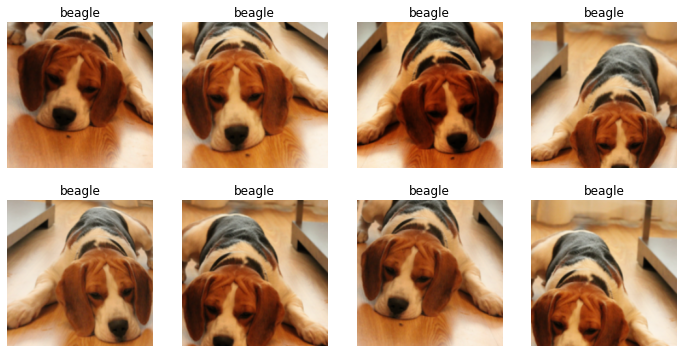

In [20]:
# Label is parsed from file name
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(224),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)
                 )
dls = pets.dataloaders(path/"images")
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## **Let's Build a Model: Float Precision**


In [21]:
# Train Model with RESNET101
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.910648,0.310849,0.092693,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.422127,0.269694,0.082544,01:16


In [22]:
# Process with half precision floats to decrase training time
learn = cnn_learner(dls, resnet101, metrics=error_rate).to_fp16()
learn.fine_tune(1)

# Notice training time is much less, but error_rate increased

epoch,train_loss,valid_loss,error_rate,time
0,0.958946,0.428209,0.112991,01:02


epoch,train_loss,valid_loss,error_rate,time
0,0.432703,0.249783,0.072395,01:12


## **Build the Model**

In [23]:
# Process with half precision floats to decrase training time
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(5)


epoch,train_loss,valid_loss,error_rate,time
0,0.958490,0.349366,0.096076,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.377181,0.378421,0.111637,01:16
1,0.382823,0.474945,0.125169,01:16
2,0.288558,0.327641,0.090663,01:16
3,0.144838,0.219502,0.061570,01:15
4,0.078733,0.215460,0.064276,01:16


[('Ragdoll', 'Birman', 6),
 ('american_pit_bull_terrier', 'american_bulldog', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('chihuahua', 'miniature_pinscher', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 5)]

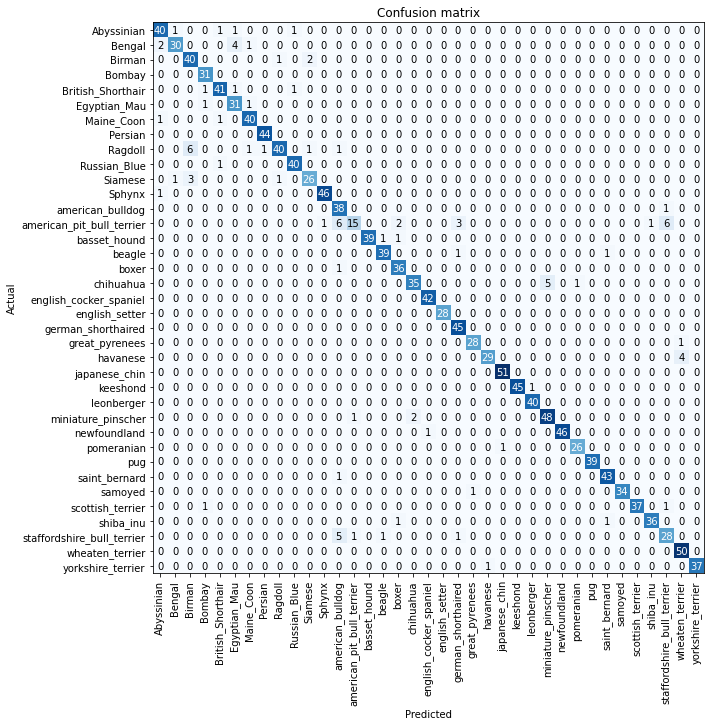

In [24]:
# Let's take a look at the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))
interp.most_confused(min_val=5)
# interp.plot_top_losses(5, nrows=5)

## **Learning Rate**

Minimum/10: 8.32e-03, steepest point: 1.20e-03


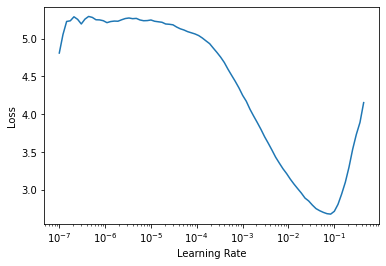

In [25]:
# Find an optimal learning rate
learn = cnn_learner(dls, resnet101, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [26]:
# Let's do some learning (MODEL BLEW UP)
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(2, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,3.133882,12.401778,0.709066,01:02


epoch,train_loss,valid_loss,error_rate,time
0,4.820681,71681.812500,0.978349,01:15
1,3.985893,122.411591,0.938430,01:15


In [27]:
# Let's try the steepest point
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(2, base_lr=8e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.255207,0.273998,0.090663,01:02


epoch,train_loss,valid_loss,error_rate,time
0,0.404426,0.254971,0.082544,01:15
1,0.260795,0.216162,0.064953,01:15


In [28]:
# Let's try 1e-3
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(2, base_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.127277,0.303893,0.100135,01:02


epoch,train_loss,valid_loss,error_rate,time
0,0.397413,0.337313,0.097429,01:15
1,0.245424,0.221117,0.063599,01:15


In [29]:
# Let's try 5e-3
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(2, base_lr=5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.794243,0.363220,0.104195,01:02


epoch,train_loss,valid_loss,error_rate,time
0,0.739173,0.733889,0.203654,01:15
1,0.411532,0.333425,0.102842,01:16


In [30]:
# Let's try 1e-2
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(2, base_lr=1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.786381,0.609702,0.142760,01:03


epoch,train_loss,valid_loss,error_rate,time
0,1.263578,0.949950,0.271989,01:16
1,0.613953,0.374514,0.118403,01:16


In [31]:
# Let's try 5e-2
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(2, base_lr=5e-2)

epoch,train_loss,valid_loss,error_rate,time
0,1.630929,20.134830,0.539919,01:03


epoch,train_loss,valid_loss,error_rate,time
0,4.141712,17.667553,0.960081,01:16
1,2.996370,2.342539,0.663058,01:16


In [32]:
# Let's try 1e-1
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(2, base_lr=1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,3.051432,10.295947,0.724628,01:03


epoch,train_loss,valid_loss,error_rate,time
0,4.757985,385.424561,0.940460,01:16
1,3.432090,2819.346191,0.789581,01:15


## **Learning Rate: Unfreeze/Transfer Learning**
it is extremely simple: use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers (and especially the randomly added layers)

Minimum/10: 6.92e-03, steepest point: 1.20e-03


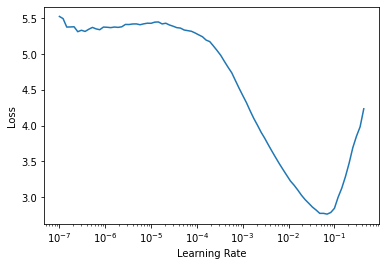

In [33]:
# Find an optimal learning rate
learn = cnn_learner(dls, resnet101, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

epoch,train_loss,valid_loss,error_rate,time
0,0.909753,1.013276,0.251691,01:02
1,0.669663,0.459496,0.130582,01:03
2,0.373179,0.301212,0.097429,01:03


Minimum/10: 1.20e-06, steepest point: 6.31e-07


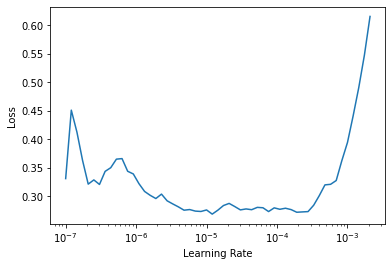

In [34]:
# Lets try Minimum/10
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fit_one_cycle(3, lr_max=6.92e-3)

learn.unfreeze()

lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

epoch,train_loss,valid_loss,error_rate,time
0,0.990557,0.305233,0.092693,01:02
1,0.423130,0.254131,0.075101,01:02
2,0.261843,0.222736,0.071719,01:02


Minimum/10: 9.12e-08, steepest point: 7.59e-07


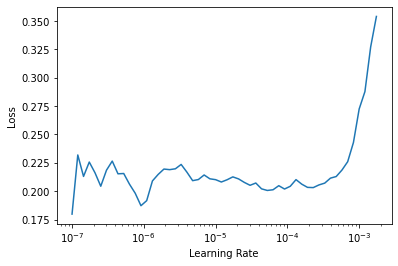

In [35]:
# Lets try steepest
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fit_one_cycle(3, lr_max=1.20e-3)

learn.unfreeze()

lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

**Unfreeze model and continue training another 6 epochs using new learning rate**

In [36]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.180686,0.206743,0.063599,01:16
1,0.180717,0.201606,0.060217,01:16
2,0.152848,0.186374,0.058863,01:16
3,0.127139,0.189721,0.062246,01:16
4,0.121673,0.191501,0.063599,01:16
5,0.109096,0.190608,0.061570,01:16


Notice the over fitting occurring in epoch 6.  Training loss is decreasing, but the validation loss increases


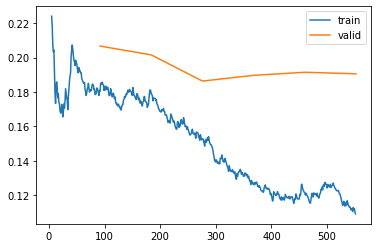

In [37]:
# Lets Plot Loss
learn.recorder.plot_loss()

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('Ragdoll', 'Birman', 7),
 ('Bengal', 'Egyptian_Mau', 5)]

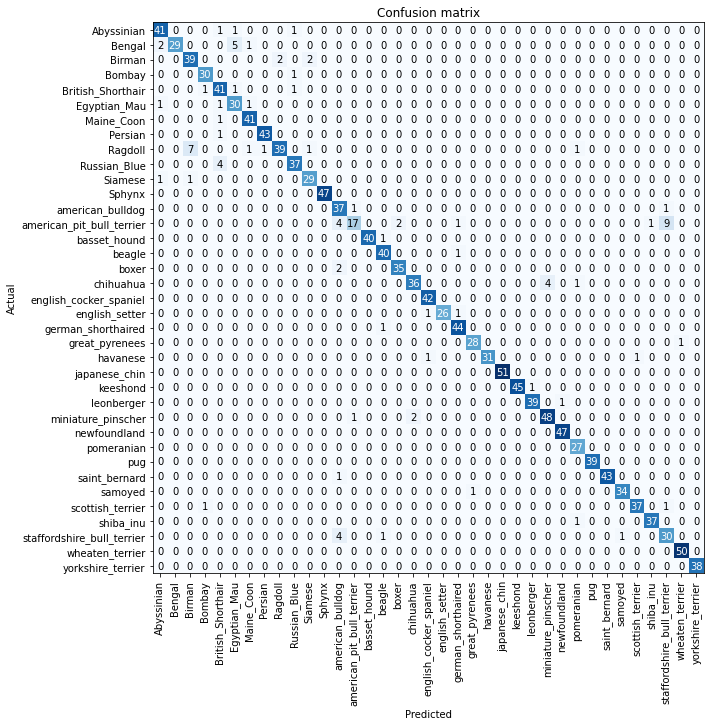

In [38]:
# Let's take a look at the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))
interp.most_confused(min_val=5)

**Let's try a slice for learning rate input:**

epoch,train_loss,valid_loss,error_rate,time
0,0.942223,0.278167,0.085927,01:03
1,0.428792,0.232484,0.070365,01:03
2,0.244482,0.211778,0.062923,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.198548,0.210785,0.064276,01:15
1,0.177907,0.203624,0.068336,01:16
2,0.160315,0.207955,0.059540,01:15
3,0.133437,0.228710,0.071042,01:15
4,0.113167,0.244949,0.069689,01:15
5,0.100655,0.219441,0.062923,01:15
6,0.088428,0.203801,0.058187,01:15
7,0.072823,0.209117,0.060893,01:15
8,0.059415,0.198807,0.058863,01:15
9,0.057949,0.201841,0.059540,01:15


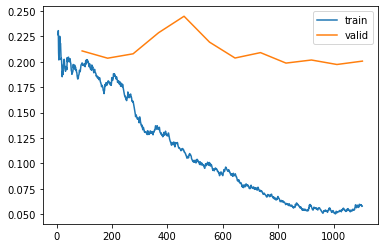

In [39]:
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fit_one_cycle(3, lr_max=1.2e-3)

learn.unfreeze()

# First layer train at 1e-6 / last layer at 1e-4
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

learn.recorder.plot_loss()

[('Ragdoll', 'Birman', 10),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('Bengal', 'Egyptian_Mau', 6),
 ('chihuahua', 'miniature_pinscher', 5)]

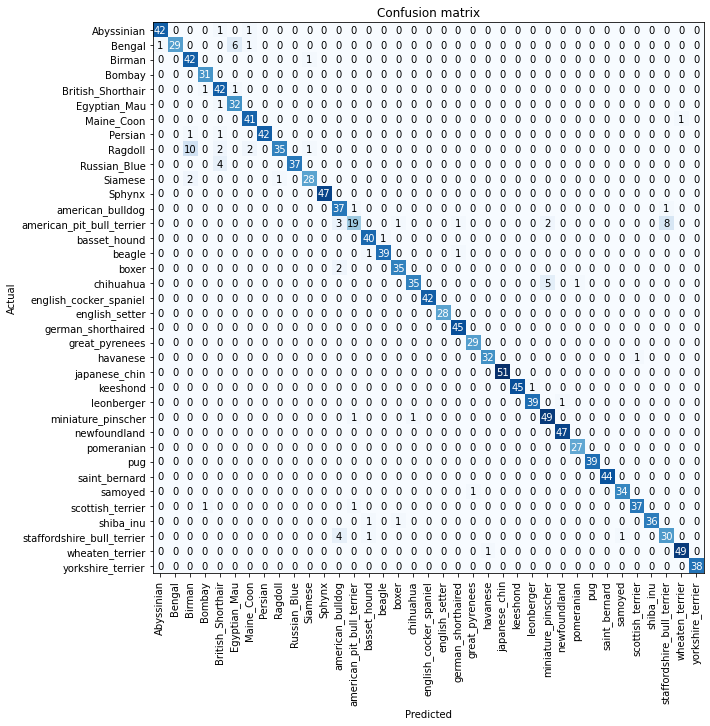

In [40]:
# Let's take a look at the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))
interp.most_confused(min_val=5)